In [ ]:
#Libraries

import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from fdspokemon import feature_extraction

In [2]:
# Getting the training data:
train_data = []
with open('train.jsonl', 'r') as file:
    for line in file:
        train_data.append(json.loads(line))

print(f"Successfully loaded {len(train_data)} battles")

# Get the test data:
test_data = []
with open('test.jsonl', 'r') as f:
    for line in f:
        test_data.append(json.loads(line))
print(f"Successfully loaded {len(test_data)} battles")

# Looking into the data:
first_battle = train_data[0]    #first entire row

# Copy the first battle and truncate the timeline for better display of data
battle_for_display = first_battle.copy()
battle_for_display['battle_timeline'] = battle_for_display.get('battle_timeline', [])[:6] #first 6 turns

# json.dumps for cleaner printing
print(json.dumps(battle_for_display, indent=4))


Successfully loaded 10000 battles
Successfully loaded 5000 battles
{
    "player_won": true,
    "p1_team_details": [
        {
            "name": "starmie",
            "level": 100,
            "types": [
                "psychic",
                "water"
            ],
            "base_hp": 60,
            "base_atk": 75,
            "base_def": 85,
            "base_spa": 100,
            "base_spd": 100,
            "base_spe": 115
        },
        {
            "name": "exeggutor",
            "level": 100,
            "types": [
                "grass",
                "psychic"
            ],
            "base_hp": 95,
            "base_atk": 95,
            "base_def": 85,
            "base_spa": 125,
            "base_spd": 125,
            "base_spe": 55
        },
        {
            "name": "chansey",
            "level": 100,
            "types": [
                "normal",
                "notype"
            ],
            "base_hp": 250,
            "base_atk": 5

In [ ]:
# Feature selection method
def feature_extraction(data:list[dict]) -> pd.DataFrame:
    
    """
    from the baseline (static features):
    a)  {Critical hits!
        p1_team max possible critical hit probability,
        p1_team avg critiical hit probability}

    from the timeline(dynamic features): 
    1. {p1_team and p2_team mean potential damage during the battle}
    2. {p1 number of missed moves and p2 number of missed moves per battle}
    3. {p1 and p2 team mean hp during the 30 rounds}
    4. {p1_team effective damage dealt from moves and/or caused by effects, and number of induced change of status}
    5. {p2_team effective damage dealt from moves and/or caused by effects, and number of induced change of status}
    6. {pokemon with a bad status for p1 and p2 in the last turn}
    """

    winning_features = []
    for battle in data:
        features = {} 
        
        p1_team = battle.get('p1_team_details', [])
        if p1_team:
        # a) --- Critical hits! ---
        # We calculate critical hits potential based on p1 pokemon speed stats
            team_speeds = [s.get('base_spe', 0) for s in p1_team]
            # Gen 1 critical hits calculation: T = base_speed/2, critical hits occur if random(0,255) < T
            crit_rates = []
            for speed in team_speeds:
                T = speed/2
                crit_probability = min(T/256, 1.0)  # probability = T/256
                crit_rates.append(crit_probability)
            
            # critical hit feature:
            features['p1_team_max_crit_rate'] = max(crit_rates) if crit_rates else 0  # because a critical hit is usually a rare event!
            features['p1_taem_avg_crit_rate'] = sum(crit_rates)/len(team_speeds) if crit_rates else 0

        # --- DYNAMIC FEATURES --- 
        timeline = battle.get('battle_timeline', [])
        
        # initialize counters for damaging moves and missed moves:
        base_power1 = 0
        base_power2 = 0
        
        null_moves1 = 0
        null_moves2 = 0
        
        p1_names = []
        p2_names = []
        
        # 1. --- p1_team and p2_team mean potential damange during battles ---
        # get their base power from move_details 
        for i in range(len(timeline)):
            x = timeline[i].get('p1_move_details')
            if (x):
                base_power1+=(x.get("base_power", 0))
            else:
                base_power1+=0
            if (x is None):
                null_moves1 += 1
            else:
                null_moves1 += 0
            #
            x = timeline[i].get('p2_move_details')
            if (x):
                base_power2+=(x.get("base_power", 0))
            else:
                base_power2+=0
            if (x is None):
                null_moves2 += 1
            else:
                null_moves2 += 0

            # get their names 
            x = timeline[i].get('p1_pokemon_state')
            if (x):
                p1name = x.get("name")
                
            x = timeline[i].get('p2_pokemon_state')
            if (x):
                p2name = x.get("name")
            p1_names.append(p1name)
            p2_names.append(p2name)
        
        p1_names = list(set(p1_names))
        p2_names = list(set(p2_names))

        #
        base_power1/=len(timeline)
        features['p1_mean_potential_damage'] = base_power1
        base_power2/=len(timeline)
        features['p2_mean_potential_damage'] = base_power2
        
        # 2. --- p1 number of missed moves and p2 number of missed moves per battle ---
        features['p1_n_missed_moves'] = null_moves1
        features['p2_n_missed_moves'] = null_moves2
        
        # to get their health points we create a new dictionary for player 1 and player 2
        p1hp = {}
        p2hp = {}

        for el in p1_names:
            p1hp[el] = 100 #starting health 
        for el in p2_names:
            p2hp[el] = 100 #starting health

        #
        for i in range(len(timeline)):
            x = timeline[i].get('p1_pokemon_state')
            if (x):
                p1hp[x.get("name")] = x.get("hp_pct")*100

            x = timeline[i].get('p2_pokemon_state')
            if (x):
                p2hp[x.get("name")] = x.get("hp_pct")*100

        # 3. --- p1 and p2 team mean hp for 30 rounds --- 
        vl1 = 0
        for el in p1hp.keys():
            vl1 += p1hp[el] 

        vl2 = 0
        for el in p2hp.keys():
            vl2 += p2hp[el] 

        vl1 = vl1 + (6-len(p1hp.keys()))*100    # each player starts with 6 pokemons 
        vl2 = vl2 + (6-len(p2hp.keys()))*100

        vl1/=6
        vl2/=6

        features['p1_r30_mean_hpt'] = vl1
        features['p2_r30_mean_hpt'] = vl2

        # initialize counters for effective moves or moves that actually landed:
        p1_damage_dealt = 0
        p1_change_of_status = 0

        p2_damage_dealt = 0
        p2_change_of_status = 0
        
        # 4. --- p1_team mean effetive damage dealt and change of status induced---
        for event in range(len(timeline)):
            p2_team_state = timeline[event].get('p2_pokemon_state')
            if p2_team_state:
                current_hp_pct = p2_team_state.get('hp_pct', float)
                if current_hp_pct < 1.0:
                    p1_damage_dealt += (1.0 - current_hp_pct)
                current_status = p2_team_state.get('status', '')
                if current_status != 'nostatus':
                    p1_change_of_status += 1

        features['p1_r30_effectively_registered_mean_damage'] = p1_damage_dealt/len(timeline)
        features['p1_change_of_status_induced'] = p1_change_of_status

        # 5. --- p2_team mean effetive damage dealt and change of status induced---
        for event in range(len(timeline)):
            p1_team_state = timeline[event].get('p1_pokemon_state')
            if p1_team_state:
                current_hp_pct = p1_team_state.get('hp_pct', float)
                if current_hp_pct < 1.0:
                    p2_damage_dealt += (1.0 - current_hp_pct)
                current_status = p1_team_state.get('status', '')
                if current_status != 'nostatus':
                    p2_change_of_status += 1

        features['p2_r30_effectively_registered_mean_damage'] = p2_damage_dealt/len(timeline) 
        features['p2_change_of_status_induced'] = p2_change_of_status        

        # 6. --- a pokemon with a bad status for p1 and p2 in the last turn ---
        if timeline:
            last_turn = timeline[-1]
            p1_status = last_turn['p1_pokemon_state']['status']
            p2_status = last_turn['p2_pokemon_state']['status']
            features['p1_bad_status_at_last'] = 1 if p1_status != 'nostatus' else 0
            features['p2_bad_status_at_last'] = 1 if p2_status != 'nostatus' else 0 

        # Battle id and target variable:
        features['battle_id'] = battle.get('battle_id')
        if 'player_won' in battle:
            features['player_won'] = int(battle['player_won'])
        
        winning_features.append(features)
    
    return pd.DataFrame(winning_features).fillna(0)

In [ ]:
# Let's apply our fucntion to the test and training data

train_df = feature_extraction(train_data)
test_df = feature_extraction(test_data) # will be used later
display(train_df.head(12))

,p1_team_max_crit_rate,p1_taem_avg_crit_rate,p1_mean_potential_damage,p2_mean_potential_damage,p1_n_missed_moves,p2_n_missed_moves,p1_r30_mean_hpt,p2_r30_mean_hpt,p1_r30_effectively_registered_mean_damage,p1_change_of_status_induced,p2_r30_effectively_registered_mean_damage,p2_change_of_status_induced,p1_bad_status_at_last,p2_bad_status_at_last,battle_id,player_won
0,0.234375,0.156250,51.833333,36.666667,3,14,64.546900,44.125036,0.440244,17,0.470836,7,0,1,0,1
1,0.214844,0.120443,67.200000,48.666667,7,7,26.333333,42.833333,0.377000,5,0.438667,11,0,1,1,1
2,0.214844,0.128581,31.700000,39.833333,3,8,69.666667,69.333333,0.214667,14,0.166000,15,1,1,2,1
3,0.214844,0.148112,51.833333,74.833333,7,5,34.000000,47.666667,0.319333,5,0.396667,20,0,0,3,1
4,0.234375,0.141602,30.300000,40.833333,4,4,62.666667,52.500000,0.349667,22,0.319000,9,0,1,4,1
5,0.253906,0.166016,45.166667,59.100000,6,7,71.166667,54.666667,0.257667,6,0.312333,11,0,1,5,1
6,0.234375,0.157878,60.166667,48.000000,5,6,26.500000,48.333333,0.230000,13,0.321333,11,0,1,6,1
7,0.234375,0.172526,10.666667,42.300000,12,4,56.833333,88.500000,0.030667,2,0.304333,18,0,1,7,1
8,0.234375,0.157878,45.000000,64.533333,4,6,27.666667,59.166667,0.132333,20,0.401667,13,1,1,8,1
9,0.234375,0.151367,44.566667,45.833333,6,5,43.326529,56.476910,0.404296,7,0.197983,13,0,0,9,1


In [5]:
# Prepare features and target for validation split
features = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]
X_features = train_df[features]
Y_target = train_df['player_won']

# Split the training data for validation
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y_target, test_size = 0.3, random_state = 42)

# Create a pipeline with preprocessing and classifier
log_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state = 42, max_iter = 5000))
])

# Train model
log_clf.fit(X_features, Y_target)

# Make predictions on validation set
Y_predicted = log_clf.predict(X_test)

# Evaluate the model(Logistic)
accuracy = accuracy_score(Y_test, Y_predicted)

print(f"\nValidation Performance:")
print(f"Logistic Accuracy: {accuracy:.4f}")



Validation Performance:
Logistic Accuracy: 0.8377


Accuracy per fold: [0.842  0.832  0.8425 0.8375 0.826 ]
Mean accuracy: 0.836
Standard deviation: 0.0063


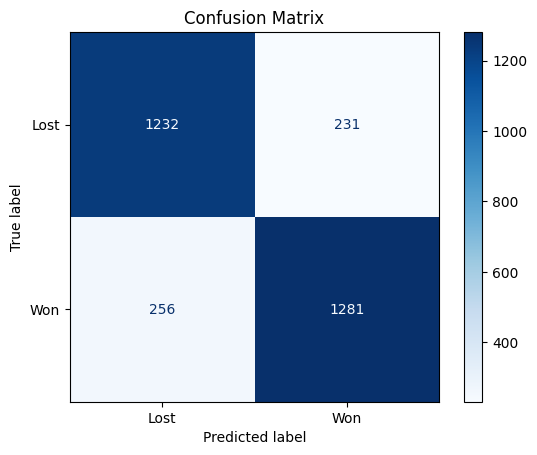

In [6]:
# Define K-Fold cross-validator
# n_splits = number of folds
# shuffle=True to randomize data before splitting
# random_state ensures reproducibility
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the model
logreg = LogisticRegression(max_iter=1000)

# We'll use a pipeline: first standardize the data, then apply logistic regression.
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000))

# Perform 5-fold cross-validation using accuracy as the metric
scores = cross_val_score(pipeline, X_features, Y_target, cv=kf, scoring='accuracy')

# Display individual fold scores and summary statistics
print("Accuracy per fold:", np.round(scores, 4))
print("Mean accuracy:", np.round(scores.mean(), 4))
print("Standard deviation:", np.round(scores.std(), 4))

# Plot confusion matrix
cm = confusion_matrix(Y_test, Y_predicted)
ConfusionMatrixDisplay(cm, display_labels=['Lost', 'Won']).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Getting ready for our submission:

X_tested = test_df[features]    #this is from the testing jsonl that our model has not yet seen
print("Generating predictions on the test set...")
test_predictions = log_clf.predict(X_tested)

q = len(test_predictions)
print(q)
print(X_test.shape)

Generating predictions on the test set...
5000
(3000, 14)


In [10]:
print("Generating predictions on the test set...")

q = len(test_predictions)

ids = [i for i in range(q)]

submission_df = pd.DataFrame({
    'battle_id': ids,
    'player_won': test_predictions
})

#our submission file 
submission_df.to_csv('submission.csv', index=False)

print("\n'submission.csv' file created successfully!")
display(submission_df.head())

Generating predictions on the test set...

'submission.csv' file created successfully!


,battle_id,player_won
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
